In [1]:
# Author: Brandon Botzer
# Date: 2/03/2024
# Class: Penn State - AI 879

Perform a watershed segmentation on the L06 sunflower.png Download L06 sunflower.png to detect the sunflowers.

You may also use an image of your choice with the proper citation.

Please consult “Marker-Controlled Watershed Segmentation” page at https://www.mathworks.com/help/images/marker-controlled-watershed-segmentation.htmlLinks to an external site.

Please explain how watershed works and justify the results.

In [19]:
# Imports for functions

# The scikit-image package provides a wide variety of filter applications
#  which reduce the need to write out the corr / conv matricies

from PIL import Image

import skimage as ski
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

# Fast sorting and coputations
import scipy as sci
from scipy.spatial.distance import cdist
from scipy.ndimage import distance_transform_edt, label
# Showing the results of scipy computations
import pandas as pd

cv.__version__, ski.__version__

('4.8.1', '0.22.0')

Get the image and look at it

In [469]:
# Image from: https://www.istockphoto.com/photo/close-up-of-a-bunch-of-ripe-red-apples-gm115684139-943649

# image = ski.io.imread('bunch-of-apples.jpg')
image = ski.io.imread('L06 sunflower.png')

In [470]:
image.shape

(594, 960, 3)

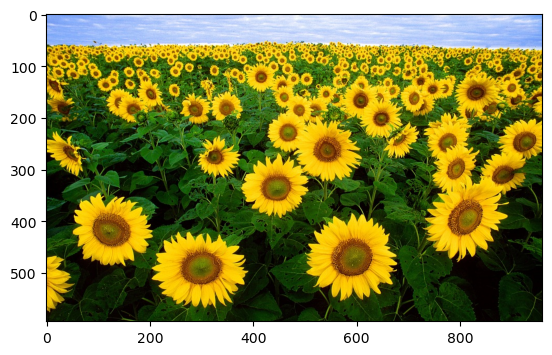

In [471]:
plt.imshow(image)

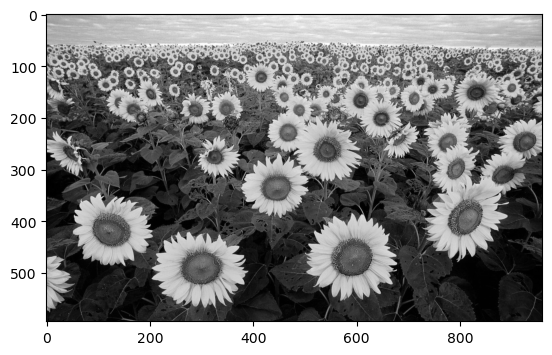

In [472]:
# Convert to grayscale
imblk = ski.color.rgb2gray(image)
plt.imshow(imblk, cmap='gray')

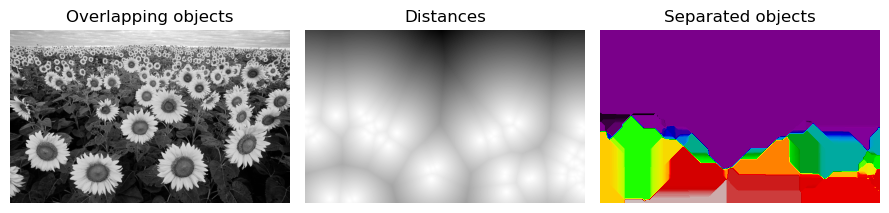

In [473]:
# Modified Skimage... doesn't do great

# Generate the markers as local maxima of the distance to the background
distance = distance_transform_edt(imblk)

# I think not including the labels=imblk is causing issues
coords = ski.feature.peak_local_max(distance, footprint=np.ones((3, 3)))#, labels=imblk)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = label(mask)
labels = ski.segmentation.watershed(-distance, markers, mask=imblk)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(imblk, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

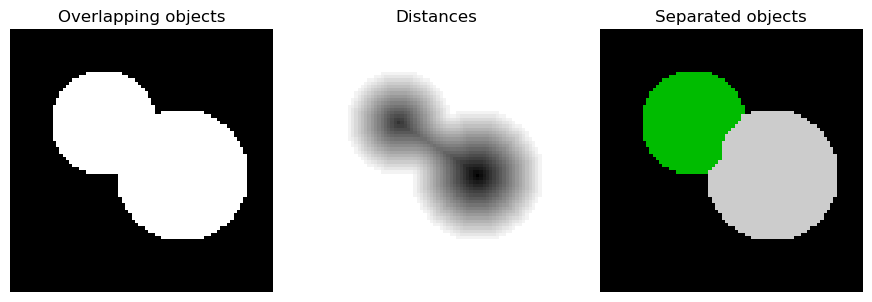

In [474]:
# As per skimage

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max


# Generate an initial image with two overlapping circles
x, y = np.indices((80, 80))
x1, y1, x2, y2 = 28, 28, 44, 52
r1, r2 = 16, 20
mask_circle1 = (x - x1)**2 + (y - y1)**2 < r1**2
mask_circle2 = (x - x2)**2 + (y - y2)**2 < r2**2
image = np.logical_or(mask_circle1, mask_circle2)

# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(image)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=image)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=image)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

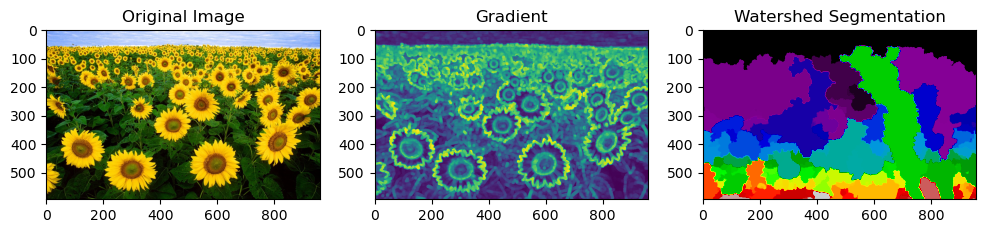

In [486]:
# As per GPT

import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters, morphology, segmentation
from scipy import ndimage

# Load an example image
# image = io.imread('bunch-of-apples.jpg')
image = ski.io.imread('L06 sunflower.png')

# Convert the image to grayscale
gray_image = color.rgb2gray(image)

# Apply gradient-based segmentation
gradient = filters.rank.gradient(gray_image, morphology.disk(5))

# Apply a marker-based watershed segmentation
markers = ndimage.label(gradient < 10)[0]
labels = segmentation.watershed(gradient, markers)

# Display the results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

ax1.imshow(image)
ax1.set_title('Original Image')

ax2.imshow(gradient, cmap='viridis')
ax2.set_title('Gradient')

ax3.imshow(labels, cmap='nipy_spectral')
ax3.set_title('Watershed Segmentation')

plt.show()


I don't think is is closing the thresholds and is resulting in the sunflowers to be sploshed out

# Try this via Matlab method using functions where needed

In [487]:
# Step 1: Read in color and convert to grayscale

# image = ski.io.imread('bunch-of-apples.jpg')
image = ski.io.imread('L06 sunflower.png')
imblk = ski.color.rgb2gray(image)


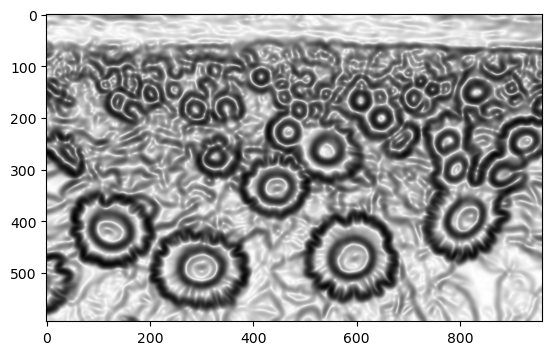

In [488]:
# Step2:  Use the Gradient Magnitude as the Segmentation Function

gmag = ski.segmentation.inverse_gaussian_gradient(imblk)
plt.imshow(gmag, cmap='gray')

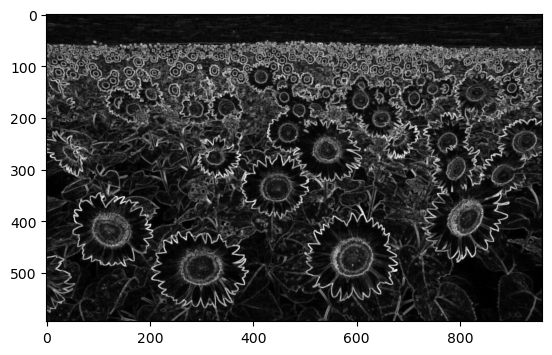

In [489]:
# Another way to do step 2
grad = ski.filters.rank.gradient(imblk, footprint=np.ones((3,3)))
plt.imshow(grad, cmap='gray')

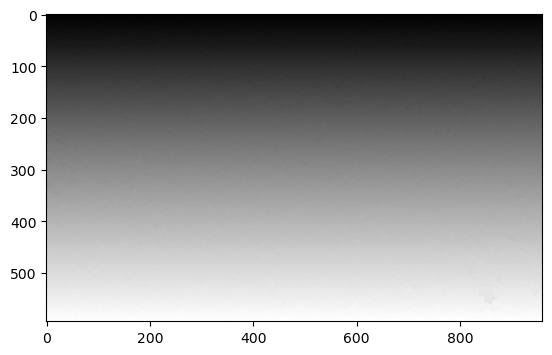

In [490]:
# Testing to see if you can run a watershed on just the gradients
#  You can't... more preprocessing is requried
water_test = ski.segmentation.watershed(grad)
plt.imshow(water_test, cmap='gray')

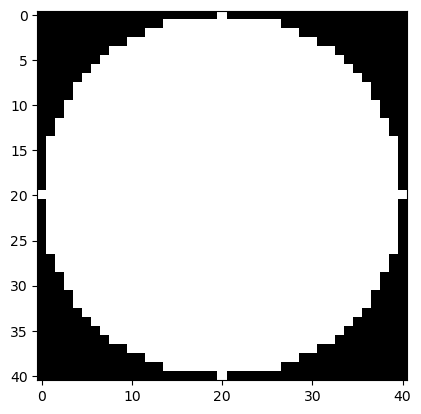

In [491]:
# Step 3: Mark the foreground objects

# Create the disc structuring element (footprint in skimage)
struct_el = ski.morphology.disk(20)
plt.imshow(struct_el, cmap='gray')

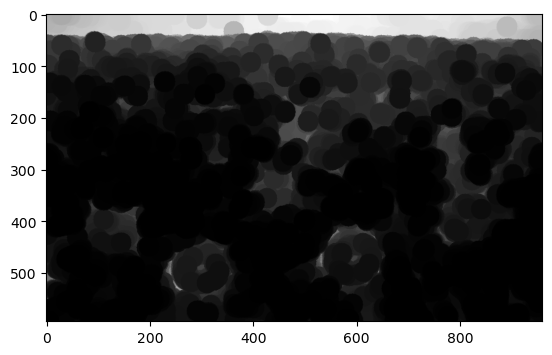

In [492]:
# Erosion
eros_im = ski.morphology.erosion(imblk, struct_el)
plt.imshow(eros_im, cmap='gray')

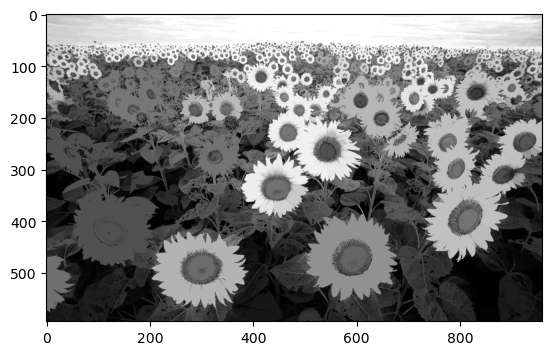

In [493]:
# Reconstruction
morph_recon = ski.morphology.reconstruction(eros_im, imblk)
plt.imshow(morph_recon, cmap='gray')

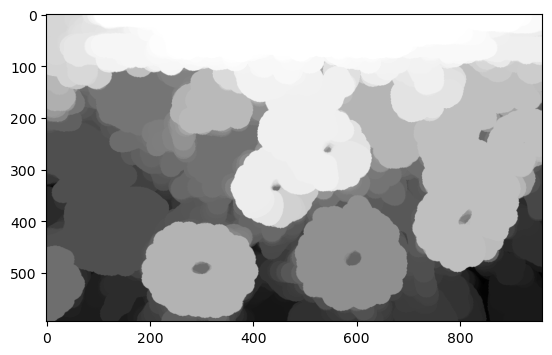

In [494]:
# Follow with a closing-by-reconstruction

# This is a dilate followed by a reconstruct
dilate_im = ski.morphology.dilation(morph_recon, struct_el)
plt.imshow(dilate_im, cmap='gray')

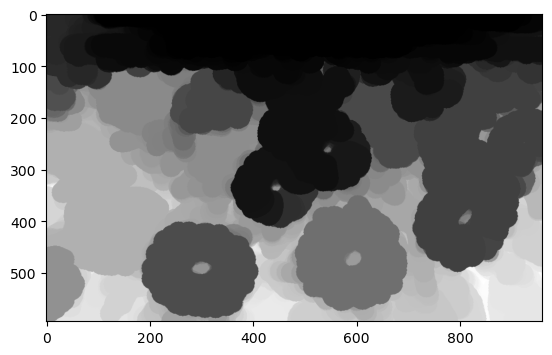

In [495]:
plt.imshow(ski.util.invert(dilate_im), cmap='gray') # To find the complement (or inversion) of an image

In [496]:
# Reconstruction without using the compliment (inversion) throws an error
morphtest_recon = ski.morphology.reconstruction(dilate_im, morph_recon)
plt.imshow(morphtest_recon, cmap='gray')

ValueError: Intensity of seed image must be less than that of the mask image for reconstruction by dilation.

In [497]:
# Reconstruction using the compliment (invert)
morph2_recon = ski.morphology.reconstruction(ski.util.invert(dilate_im), ski.util.invert(morph_recon))
# re-invert the image
morph2_recon_inv = ski.util.invert(morph2_recon)


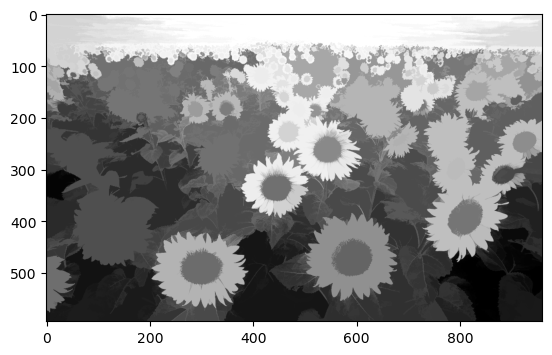

In [498]:
plt.imshow(morph2_recon_inv, cmap='gray')

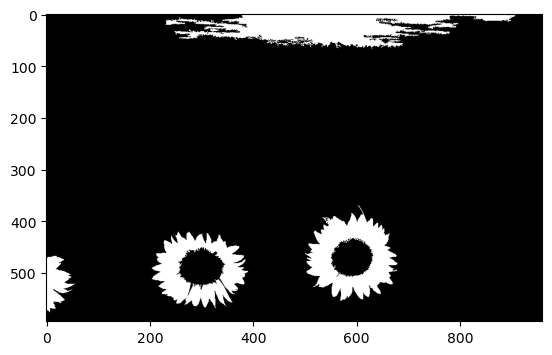

In [499]:
# Calculate the regional maxima

foreground_markers = ski.morphology.local_maxima(morph2_recon_inv)
plt.imshow(foreground_markers, cmap='gray')


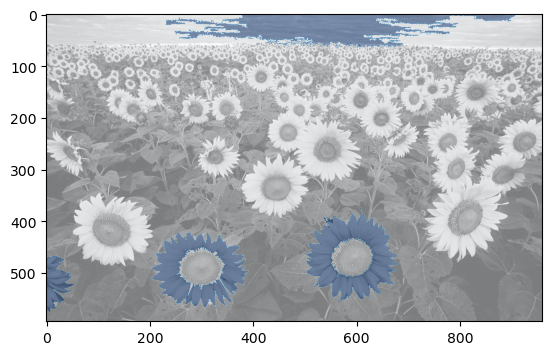

In [502]:
# show the overlay

fig, ax = plt.subplots()
# Plot origional grayscale image
ax.imshow(imblk, cmap='gray')
# Plot the forground markers on top
ax.imshow(foreground_markers, alpha=0.5, cmap='Blues')
plt.show()

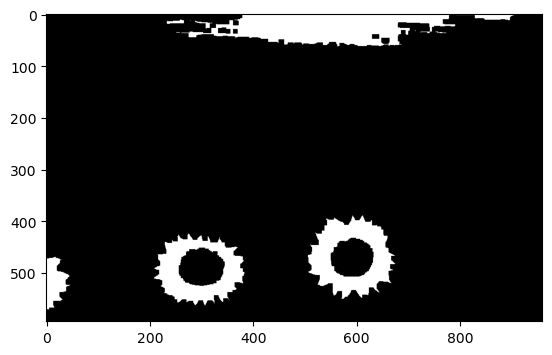

In [503]:
# Clean up the edges of the marker blobs

# This is done with a closing followed by an erosion

# New square structing element (footprint)
struct_el2 = ski.morphology.square(5)

# Closing
foreground_markers2 = ski.morphology.closing(foreground_markers, struct_el2)

# Erosion
foreground_markers3 = ski.morphology.erosion(foreground_markers2, struct_el2)

plt.imshow(foreground_markers3, cmap='gray')

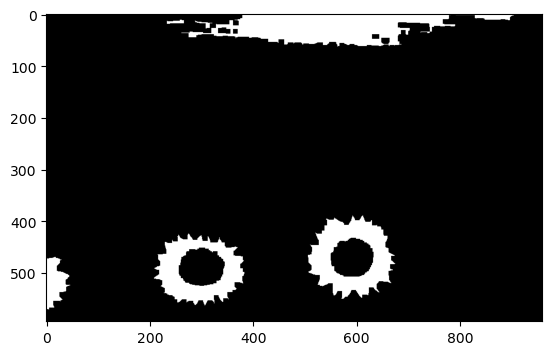

In [504]:
# If there are stray isolated pixels, they can be removed with and area_open

foreground_markers4 = ski.morphology.area_opening(foreground_markers3, area_threshold=30, connectivity=2)

plt.imshow(foreground_markers4, cmap='gray')

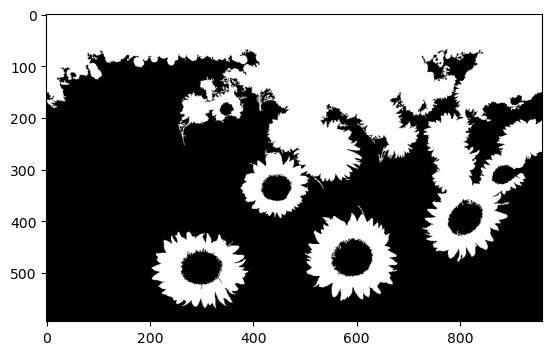

In [505]:
# Now we must compute the background markers

# While there are many ways to do thresholding, I will use Otsu's method to minimize intra-class variance.
# This is the same method that Matlab uses by default

thresh_otsu = ski.filters.threshold_otsu(morph2_recon_inv)

bw = morph2_recon_inv > thresh_otsu

plt.imshow(bw, cmap='gray')

Note the the background here (the sky) has been masked out as well.

In [ ]:
# Thin the background by computing the 'skeleton of inclunce zones' SKIZ.

# Do this by computing the watershed transform of the bw image and then looking for the watershed ridge lines (DL==0) of the result.

# I am having trouble getting ski.morphology.reconstruction() to work the same way as matlabs imimposemin() function.

# When I used just the bw image, I had poor results.  Inverting it gave me something better.
# I found that some examples used the compliment (inversion) while some did not.
#  Using the inversion: https://www.mathworks.com/help/images/ref/watershed.html
#  Not using the inversion: https://www.mathworks.com/help/images/marker-controlled-watershed-segmentation.html


With the preprocessed image (bw) I'll now try to implement the process outlined by skimage

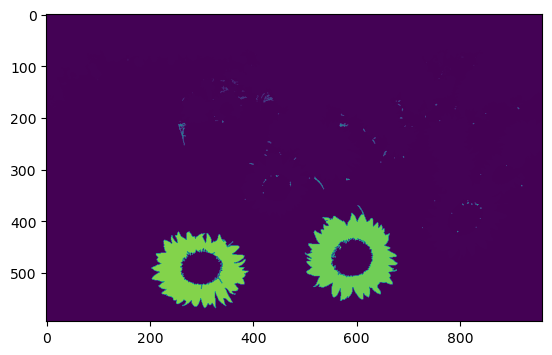

In [506]:
# I'll make labels of the conected regions of the bw image (I may not need these)
bw_labels, num_features = ndi.label(bw)
plt.imshow(bw_labels)

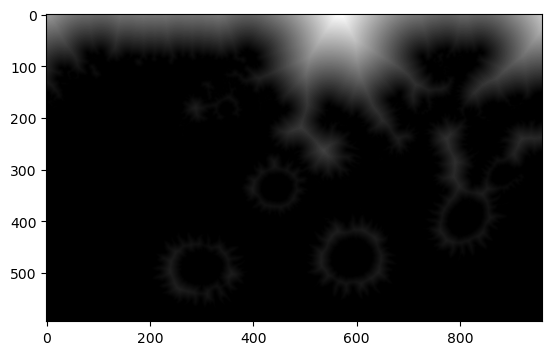

In [507]:
# What I'll do instead is use the distance transform based on the binarized image (which took lots of preprocessing to achieve)
#  This should give me a better chance to perform a better
dist_d = ndi.distance_transform_edt(bw)
plt.imshow(dist_d, cmap='gray')

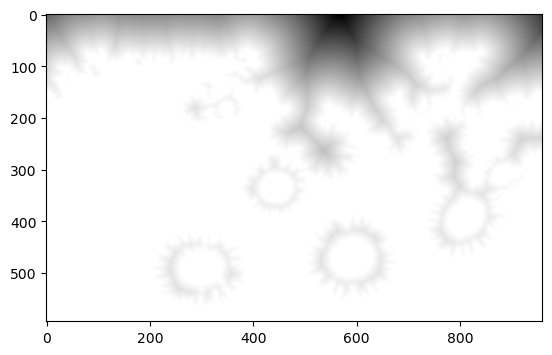

In [508]:
plt.imshow(ski.util.invert(dist_d), cmap='gray')

In [509]:
# Find coordinates for the peak_local_max based on the distance plot
crds = ski.feature.peak_local_max(dist_d, footprint = ski.morphology.square(3), labels=bw_labels)
crds.shape

(2913, 2)

In [510]:
# Create a mask 2d array
mask = np.zeros(dist_d.shape, dtype=bool)
# Take the coordinates from peak_local_max and cast them as x,y coords
mask[tuple(crds.T)] = True


594


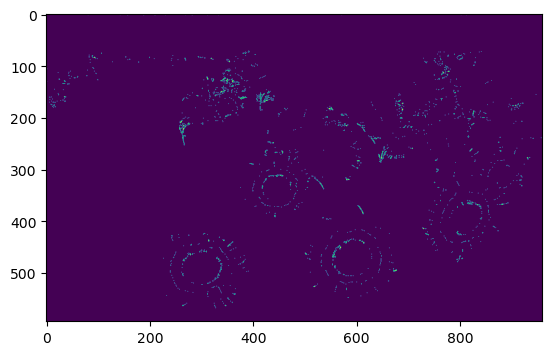

In [511]:
plt.imshow(mask, cmap='gray')
print(len(mask))

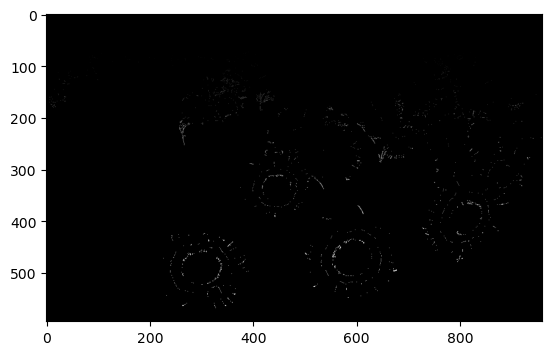

In [512]:
markers, _ = ndi.label(mask)
plt.imshow(markers, cmap='gray')


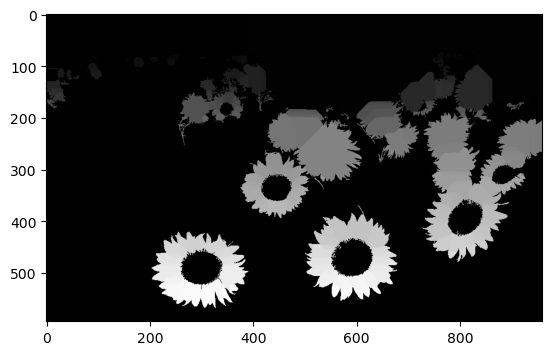

In [513]:
labels = watershed(-dist_d, markers, mask=bw)
plt.imshow(labels, cmap='gray')

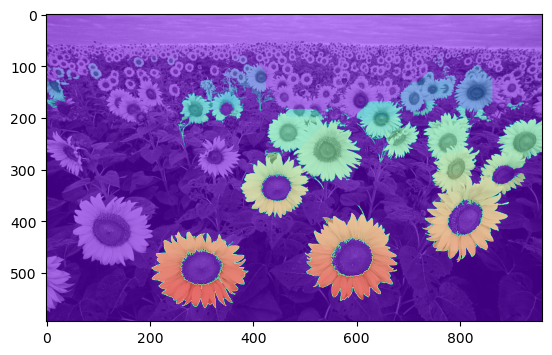

In [514]:
# show the overlay
fig, ax = plt.subplots()
# Plot origional grayscale image
ax.imshow(imblk, cmap='gray')
# Plot the forground markers on top
ax.imshow(labels, alpha=0.5, cmap='rainbow')
plt.show()

A number of the sunflowers have been found.  It is difficult to see, but the top 1/4 of the image (distanct flowers and sky) has also been tagged as a different label color.

Chat GPT with preprocessed image

In [515]:
dist_d.min()

0.0

In [516]:
dist_d.max()

175.5135322418189

In [517]:
bw.max()

True

c:\Users\btb51\anaconda3\envs\ai879_basic\Lib\site-packages\skimage\filters\rank\generic.py:268: UserWarning: Bad rank filter performance is expected due to a large number of bins (65536), equivalent to an approximate bitdepth of 16.0.
  image, footprint, out, mask, n_bins = _preprocess_input(image, footprint,


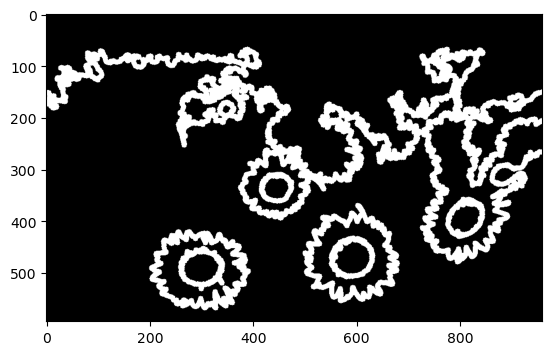

In [518]:
grad_bw = ski.filters.rank.gradient(ski.util.img_as_uint(bw), ski.morphology.disk(5))
plt.imshow(grad_bw, cmap='gray')


In [519]:
len(grad_bw<10)

594

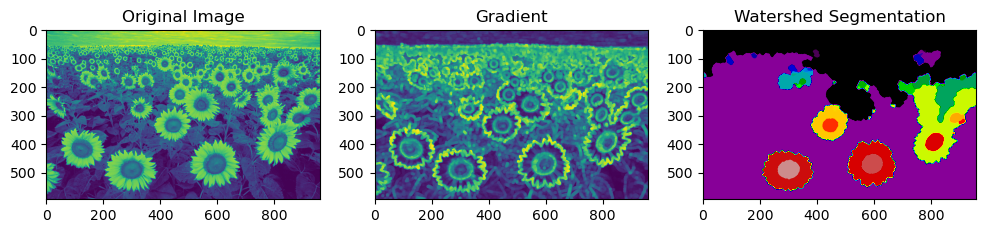

In [520]:
# Apply a marker-based watershed segmentation
# Find plateaus in the image
markers = ndimage.label(grad_bw < 10)[0]
# Run a watershed using the gradient and the markers
labels = segmentation.watershed(grad_bw, markers)

# Display the results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

ax1.imshow(imblk)
ax1.set_title('Original Image')

ax2.imshow(gradient, cmap='viridis')
ax2.set_title('Gradient')

ax3.imshow(labels, cmap='nipy_spectral')
ax3.set_title('Watershed Segmentation')

plt.show()

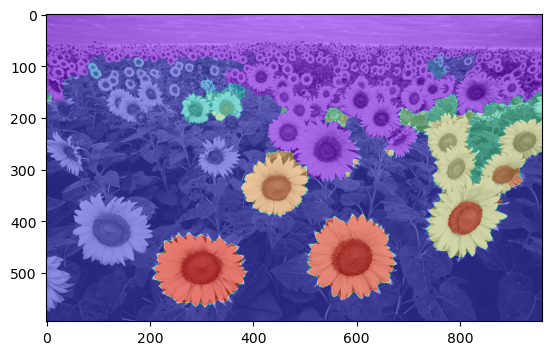

In [521]:
# show the overlay
fig, ax = plt.subplots()
# Plot origional grayscale image
ax.imshow(imblk, cmap='gray')
# Plot the forground markers on top
ax.imshow(labels, alpha=0.5, cmap='rainbow')
plt.show()

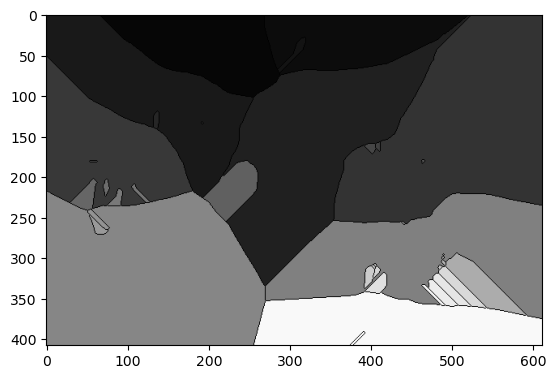

In [275]:
# Watershed - Make sure you return the lines or else you won't have regions that hit dl == 0
dl = ski.segmentation.watershed(dist_d, watershed_line=True)
plt.imshow(dl, cmap='gray')

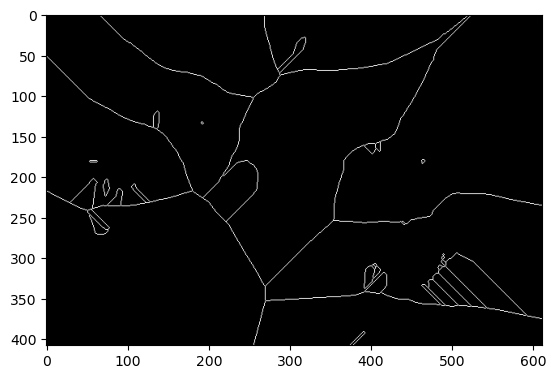

In [276]:
# Find the backgrond markers (the watershed lines)
bgm = dl == 0
plt.imshow(bgm, cmap='gray')

I need to apply a redconstruction of regional minimum only in certain desired locations.

This is done using the reconstruction function again.  I'm having problems with it...

In [288]:
gmag2 = ski.morphology.reconstruction(ski.util.invert(bgm|foreground_markers4), gmag)
plt.imshow(gmag2, cmap='gray')

ValueError: Intensity of seed image must be less than that of the mask image for reconstruction by dilation.

In [283]:
bgm|foreground_markers4

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

In [289]:
foreground_markers4

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

In [293]:
fgm4_bool = foreground_markers4.astype(bool)
bgm_bool = bgm.astype(bool)

In [299]:
gmag2 = ski.morphology.reconstruction(grad, ski.util.invert(bgm_bool|fgm4_bool))
plt.imshow(gmag2, cmap='gray')

ValueError: Intensity of seed image must be less than that of the mask image for reconstruction by dilation.

In [300]:
x = grad - (bgm_bool|fgm4_bool)

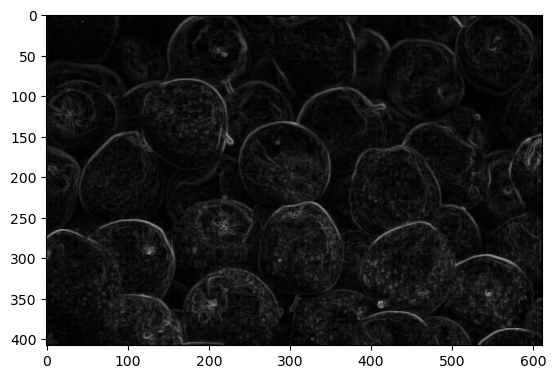

In [303]:
plt.imshow(x, cmap='gray')

In [ ]:
x = ski.segmentation.watershed()